# Convolutional Neural Network

In [1]:
import pandas as pd
from finlab.data import Data
data = Data()
twii = data.get("發行量加權股價指數")
twii = twii['台股指數']
twii = twii.resample('15T').first().dropna()

## 製作features

In [3]:
import numpy as np
import tqdm
time_period = 200

cnn_x = []
cnn_y = []
indexs = []
for i in tqdm.tqdm_notebook(range(0, len(twii) - time_period - 1 - 11, 3)):
    s = twii.iloc[i:i+time_period].values
    cnn_x.append((s - s.min())/(s.max() - s.min()))
    r = twii.iloc[i+time_period+10] / twii.iloc[i+time_period-1]
    cnn_y.append(r)
    indexs.append(twii.index[i+time_period-1])

cnn_x = np.array(cnn_x)
cnn_y = np.array(cnn_y)
indexes = np.array(indexs)




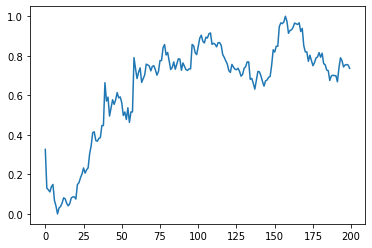

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(cnn_x[0])

In [14]:
cnn_x.shape

(22090, 200)

## Reshape features and labels

In [15]:
cnn_x = cnn_x.reshape(len(cnn_x), time_period, 1)
cnn_y = cnn_y.reshape(len(cnn_y), 1)

## Split traning and testing data

In [21]:
indexes

array([Timestamp('2006-01-16 11:15:00'), Timestamp('2006-01-16 12:00:00'),
       Timestamp('2006-01-16 12:45:00'), ...,
       Timestamp('2020-03-05 13:15:00'), Timestamp('2020-03-06 09:15:00'),
       Timestamp('2020-03-06 10:00:00')], dtype=object)

In [16]:
import datetime
cnn_x_train = cnn_x[indexes < datetime.datetime(2018,1,1)]
cnn_y_train = cnn_y[indexes < datetime.datetime(2018,1,1)]

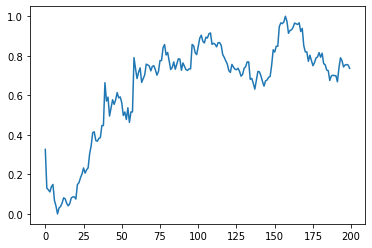

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(cnn_x[0].reshape(1, len(cnn_x[0]))[0])


In [ ]:
import keras
keras.applications.inception_resnet_v2.InceptionResNetV2(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000)

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
 24510464/225209952 [==>...........................] - ETA: 23:03

## CNN

In [ ]:
import keras.layers as layers
import keras
from keras.models import Sequential
from keras.initializers import he_normal

input_shape = cnn_x[0].shape
time_period = 200
num_classes = 1


model_m = Sequential()

model = keras.Sequential()

model.add(layers.Conv1D(filters=20, kernel_size=20, activation='relu', input_shape=cnn_x[0].shape))
model.add(layers.AveragePooling1D(5))

model.add(layers.Conv1D(filters=20, kernel_size=20, activation='relu'))
model.add(layers.AveragePooling1D(5))
model.add(layers.Flatten())
model.add(layers.Dense(units=120, activation='relu'))
model.add(layers.Dense(units=84, activation='relu'))
model.add(layers.Dense(units=1, ))#activation = 'softmax'))

adam = keras.optimizers.Adam(lr=0.0005, beta_1=0.9, beta_2=0.99, epsilon=None, decay=0.01, amsgrad=False)

model.compile(loss='mse',
                optimizer=adam)

print(model.summary())

history = model.fit(cnn_x_train, cnn_y_train,
                    batch_size=200,
                    epochs=50,
                    verbose=1,
                    validation_split=0.1, )

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 181, 20)           420       
_________________________________________________________________
average_pooling1d_1 (Average (None, 36, 20)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 17, 20)            8020      
_________________________________________________________________
average_pooling1d_2 (Average (None, 3, 20)             0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 60)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 120)               7320      
_________________________________________________________________
dense_2 (Dense)              (None, 84)                10164     
__________

In [14]:
import keras.layers as layers
import keras
from keras.models import Sequential
from keras.initializers import he_normal

input_shape = cnn_x[0].shape
time_period = 200
num_classes = 1


model_m = Sequential()

model = keras.Sequential()

model.add(layers.Conv1D(filters=20, kernel_size=20, activation='relu', input_shape=cnn_x[0].shape))
model.add(layers.AveragePooling1D(5))

model.add(layers.Conv1D(filters=20, kernel_size=20, activation='relu'))
model.add(layers.AveragePooling1D(5))
model.add(layers.Flatten())
model.add(layers.Dense(units=120, activation='relu'))
model.add(layers.Dense(units=84, activation='relu'))
model.add(layers.Dense(units=1, ))#activation = 'softmax'))

adam = keras.optimizers.Adam(lr=0.0005, beta_1=0.9, beta_2=0.99, epsilon=None, decay=0.01, amsgrad=True)

model.compile(loss='mse',
                optimizer=adam)

print(model.summary())

history = model.fit(cnn_x_train, cnn_y_train,
                    batch_size=200,
                    epochs=50,
                    verbose=1,
                    validation_split=0.1, )


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, 181, 20)           420       
_________________________________________________________________
average_pooling1d_3 (Average (None, 36, 20)            0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 17, 20)            8020      
_________________________________________________________________
average_pooling1d_4 (Average (None, 3, 20)             0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 60)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 120)               7320      
_________________________________________________________________
dense_5 (Dense)              (None, 84)                10164     
__________

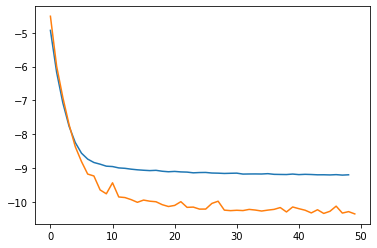

In [25]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(np.log(history.history['loss'][1:]))
plt.plot(np.log(history.history['val_loss']))

In [26]:
ey = model.predict(cnn_x)
ey = pd.Series(ey.swapaxes(0, 1)[0], index=indexes)

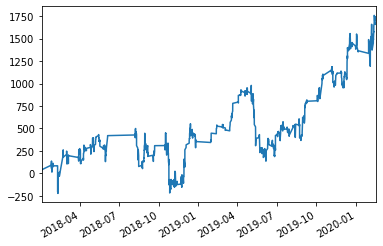

In [30]:
eq = twii[pd.to_datetime(indexes)]
pct_change = (eq.shift(-1) - eq) 

signal = (ey > ey.quantile(0.9)).rolling(20).sum() > 0
eq = (gain[signal])['2018':].cumsum()
eq.plot()

In [1]:
plt = pct_change[((ey>1.01).rolling(20).sum() > 0)]['2018':]
plt.plot()

NameError: name 'pct_change' is not defined

In [50]:
pct_change[((ey>1.01).rolling(20).sum() > 0)]['2018']

2018-03-30 10:45:00     -1.25
2018-03-30 11:30:00     -6.97
2018-03-30 12:15:00     -9.80
2018-03-30 13:00:00    -30.03
2018-03-31 09:00:00     26.36
2018-03-31 09:45:00      3.70
2018-03-31 10:30:00     -6.86
2018-03-31 11:15:00     -6.95
2018-03-31 12:00:00     -3.07
2018-03-31 12:45:00      0.09
2018-03-31 13:30:00     44.73
2018-04-02 09:30:00    -20.19
2018-04-02 10:15:00    -47.84
2018-04-02 11:00:00      9.19
2018-04-02 11:45:00      1.33
2018-04-02 12:30:00    -13.38
2018-04-02 13:15:00    -95.33
2018-04-03 09:15:00     -0.28
2018-04-03 10:00:00      5.58
2018-04-03 10:45:00     -6.88
2018-04-03 11:30:00      2.28
2018-04-03 12:15:00     16.71
2018-04-03 13:00:00      6.12
2018-04-09 09:00:00     37.16
2018-04-09 09:45:00    -22.26
2018-04-09 10:30:00     32.80
2018-04-09 11:15:00     19.52
2018-04-09 12:00:00      0.17
2018-04-09 12:45:00      4.61
2018-04-09 13:30:00     18.97
                        ...  
2018-11-06 09:00:00    -29.46
2018-11-06 09:45:00    -38.80
2018-11-06

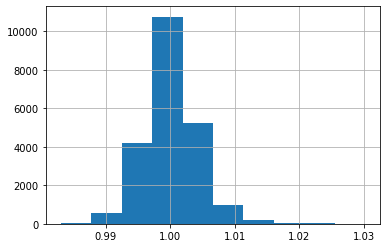

In [32]:
ey.hist()